# **ALCALDES**

De los .XSLX sacados del gobierno se leerá los ficheros de una carpeta XSLX.

Y se añadirá en una nueva columna los nombres limpiados en mayúsculas

In [2]:
import pathlib
XSLX=str(pathlib.Path().resolve())+"/XSLX"
from os import listdir
from os.path import isfile, join

ficherosXSLX = [f for f in listdir(XSLX) if isfile(join(XSLX, f))] #Tenemos en la variable ficherosXSLX la lista de ficheros de la carpeta

In [3]:
import pandas as pd


def cargaAlcaldes(archivo, columna, fila, cabecera, nombreHoja):
    return pd.read_excel(archivo, sheet_name=nombreHoja,
         names=cabecera, usecols=columna, skiprows=fila)

dfAlcaldes = pd.DataFrame([])

for fichero in ficherosXSLX:
    """
    Con los ficheros leidos en el paso anterior se leerá de 1 en 1 de la lista con el método de cargaAlcaldes
    """
    print(fichero)
    dfAlcaldes = pd.concat([dfAlcaldes,
                            cargaAlcaldes(XSLX+"/"+fichero,"D:K",8,
        ['CCAA', 'PROVINCIA', 'MUNICIPIO', 'CODIGO INE', 'NOMBRE','LISTA','FECHA POSESIÓN','FECHA BAJA'], 
        pd.ExcelFile(XSLX+"/"+fichero).sheet_names[0])],)




Alcaldes_Mandato_1979_1983.xlsx
Alcaldes_Mandato_1983_1987.xlsx
Alcaldes_Mandato_1987_1991.xlsx
Alcaldes_Mandato_1991_1995.xlsx
Alcaldes_Mandato_1995_1999.xlsx
Alcaldes_Mandato_1999_2003.xlsx
Alcaldes_Mandato_2003_2007.xlsx
Alcaldes_Mandato_2007_2011.xlsx
Alcaldes_Mandato_2011_2015.xlsx
Alcaldes_Mandato_2015_2019.xlsx
Alcaldes_Mandato_2019_2023.xlsx


**Limpieza de datos**

In [4]:
import re
import string
import unicodedata

def transformar_fecha(columna,dataFrame):
    dataFrame[columna]=(dataFrame[columna].astype(str))
    dataFrame.loc[dataFrame[columna] == 'SIN FECHA', columna] = pd.NA
    dataFrame[columna]=pd.to_datetime((dataFrame[columna].str.replace("-","/").str[:10]),format='mixed')
    return dataFrame

"""
    Remplaza todos los signos de puntuación por vacío eliminando '.,'...
    Cambia la normalización con el encode ASCII y lo descodifica a UTF-8 español para eliminar todas las tildes
    Convierte todo a UPPER para que los nombres estén en mayúscula
"""
dfAlcaldes['NOMBRE NORMALIZADO']=(dfAlcaldes['NOMBRE']
                                  .str.replace('[{}]'.format(string.punctuation), '',regex=True)
                                  .str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper())


dfAlcaldes = transformar_fecha("FECHA POSESIÓN",dfAlcaldes)
dfAlcaldes = transformar_fecha("FECHA BAJA",dfAlcaldes)
dfAlcaldes=dfAlcaldes.drop_duplicates()


In [5]:
dfAlcaldes

,CCAA,PROVINCIA,MUNICIPIO,CODIGO INE,NOMBRE,LISTA,FECHA POSESIÓN,FECHA BAJA,NOMBRE NORMALIZADO
0,Andalucía,Almería,ABRUCENA,040025,"MARTINEZ LAO, JUAN",PSOE,1979-04-19,NaT,MARTINEZ LAO JUAN
1,Andalucía,Almería,ADRA,040031,"SARMIENTO POSADA, PEDRO",OTROS,1979-04-19,NaT,SARMIENTO POSADA PEDRO
2,Andalucía,Almería,ALBANCHEZ,040046,"MARTOS AYBAR, RAMON",UCD,1979-04-19,NaT,MARTOS AYBAR RAMON
3,Andalucía,Almería,ALBOLODUY,040059,"BLANES PANIAGUA, MARIANO",UCD,1979-04-19,NaT,BLANES PANIAGUA MARIANO
4,Andalucía,Almería,ALBOX,040062,"MIRAS CARRASCO, JOSE",UCD,1979-04-19,NaT,MIRAS CARRASCO JOSE
...,...,...,...,...,...,...,...,...,...
8758,"Rioja, La","Rioja, La",Viniegra de Abajo,261780,Juan Ignacio Martínez Fernández,PP,2019-06-15,NaT,JUAN IGNACIO MARTINEZ FERNANDEZ
8759,"Rioja, La","Rioja, La",Viniegra de Arriba,261793,Laura Crespi Lázaro,PP,2019-06-15,NaT,LAURA CRESPI LAZARO
8760,"Rioja, La","Rioja, La",Zarratón,261807,Víctor Manuel Manso Ocio,PSOE,2019-06-15,NaT,VICTOR MANUEL MANSO OCIO
8761,"Rioja, La","Rioja, La",Zarzosa,261814,José María Sáenz Blanco,PP,2019-06-15,NaT,JOSE MARIA SAENZ BLANCO


**ALCALDES QUE REPITIERON ALCALDÍA**

In [6]:
df_duplicated = dfAlcaldes[dfAlcaldes.duplicated(subset=['NOMBRE NORMALIZADO'], keep=False)]
# Contar el número de filas duplicadas por cada valor en 'NOMBRE NORMALIZADO'
duplicated_counts = df_duplicated.groupby(['NOMBRE NORMALIZADO']).size()

# Añadir la cuenta de duplicados como una nueva columna en df_duplicated
df_duplicated['DUPLICADOS'] = df_duplicated['NOMBRE NORMALIZADO'].map(duplicated_counts)

C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\3495335515.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['DUPLICADOS'] = df_duplicated['NOMBRE NORMALIZADO'].map(duplicated_counts)


**CUANDO FUE SU PRIMERA ALCALDÍA**

In [7]:
min_dates = df_duplicated.groupby('NOMBRE NORMALIZADO')['FECHA POSESIÓN'].min()

df_duplicated['PRIMERA ALCALDÍA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)

df_duplicated

C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\329941580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['PRIMERA ALCALDÍA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)


,CCAA,PROVINCIA,MUNICIPIO,CODIGO INE,NOMBRE,LISTA,FECHA POSESIÓN,FECHA BAJA,NOMBRE NORMALIZADO,DUPLICADOS,PRIMERA ALCALDÍA
1,Andalucía,Almería,ADRA,040031,"SARMIENTO POSADA, PEDRO",OTROS,1979-04-19,NaT,SARMIENTO POSADA PEDRO,2,1979-04-19
2,Andalucía,Almería,ALBANCHEZ,040046,"MARTOS AYBAR, RAMON",UCD,1979-04-19,NaT,MARTOS AYBAR RAMON,2,1979-04-19
3,Andalucía,Almería,ALBOLODUY,040059,"BLANES PANIAGUA, MARIANO",UCD,1979-04-19,NaT,BLANES PANIAGUA MARIANO,2,1979-04-19
4,Andalucía,Almería,ALBOX,040062,"MIRAS CARRASCO, JOSE",UCD,1979-04-19,NaT,MIRAS CARRASCO JOSE,2,1979-04-19
10,Andalucía,Almería,ALICUN,040123,"GONZALEZ MARTINEZ, JUAN",IND,1979-04-19,NaT,GONZALEZ MARTINEZ JUAN,3,1979-04-19
...,...,...,...,...,...,...,...,...,...,...,...
8758,"Rioja, La","Rioja, La",Viniegra de Abajo,261780,Juan Ignacio Martínez Fernández,PP,2019-06-15,NaT,JUAN IGNACIO MARTINEZ FERNANDEZ,2,2015-06-13
8759,"Rioja, La","Rioja, La",Viniegra de Arriba,261793,Laura Crespi Lázaro,PP,2019-06-15,NaT,LAURA CRESPI LAZARO,2,2015-06-13
8760,"Rioja, La","Rioja, La",Zarratón,261807,Víctor Manuel Manso Ocio,PSOE,2019-06-15,NaT,VICTOR MANUEL MANSO OCIO,2,2015-06-13
8761,"Rioja, La","Rioja, La",Zarzosa,261814,José María Sáenz Blanco,PP,2019-06-15,NaT,JOSE MARIA SAENZ BLANCO,4,2007-06-16


**ÚLTIMA ALCALDÍA**

In [8]:
min_dates = df_duplicated.groupby('NOMBRE NORMALIZADO')['FECHA POSESIÓN'].max()

df_duplicated['COMIENZO ÚLTIMA ALCALDÍA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)

C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\343191971.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['COMIENZO ÚLTIMA ALCALDÍA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)


**VECES DE BAJA**

In [9]:
df_duplicated['VECES F.BAJA'] = df_duplicated['FECHA BAJA'].notna().astype(int)

min_dates = df_duplicated.groupby('NOMBRE NORMALIZADO')['VECES F.BAJA'].sum()

df_duplicated['VECES F.BAJA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)

C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\562087554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['VECES F.BAJA'] = df_duplicated['FECHA BAJA'].notna().astype(int)
C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\562087554.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_duplicated['VECES F.BAJA'] = df_duplicated['NOMBRE NORMALIZADO'].map(min_dates)


In [10]:
df_duplicated

,CCAA,PROVINCIA,MUNICIPIO,CODIGO INE,NOMBRE,LISTA,FECHA POSESIÓN,FECHA BAJA,NOMBRE NORMALIZADO,DUPLICADOS,PRIMERA ALCALDÍA,COMIENZO ÚLTIMA ALCALDÍA,VECES F.BAJA
1,Andalucía,Almería,ADRA,040031,"SARMIENTO POSADA, PEDRO",OTROS,1979-04-19,NaT,SARMIENTO POSADA PEDRO,2,1979-04-19,1983-05-23,0
2,Andalucía,Almería,ALBANCHEZ,040046,"MARTOS AYBAR, RAMON",UCD,1979-04-19,NaT,MARTOS AYBAR RAMON,2,1979-04-19,1983-05-23,0
3,Andalucía,Almería,ALBOLODUY,040059,"BLANES PANIAGUA, MARIANO",UCD,1979-04-19,NaT,BLANES PANIAGUA MARIANO,2,1979-04-19,1983-05-24,0
4,Andalucía,Almería,ALBOX,040062,"MIRAS CARRASCO, JOSE",UCD,1979-04-19,NaT,MIRAS CARRASCO JOSE,2,1979-04-19,1983-05-23,1
10,Andalucía,Almería,ALICUN,040123,"GONZALEZ MARTINEZ, JUAN",IND,1979-04-19,NaT,GONZALEZ MARTINEZ JUAN,3,1979-04-19,1987-06-30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8758,"Rioja, La","Rioja, La",Viniegra de Abajo,261780,Juan Ignacio Martínez Fernández,PP,2019-06-15,NaT,JUAN IGNACIO MARTINEZ FERNANDEZ,2,2015-06-13,2019-06-15,0
8759,"Rioja, La","Rioja, La",Viniegra de Arriba,261793,Laura Crespi Lázaro,PP,2019-06-15,NaT,LAURA CRESPI LAZARO,2,2015-06-13,2019-06-15,0
8760,"Rioja, La","Rioja, La",Zarratón,261807,Víctor Manuel Manso Ocio,PSOE,2019-06-15,NaT,VICTOR MANUEL MANSO OCIO,2,2015-06-13,2019-06-15,0
8761,"Rioja, La","Rioja, La",Zarzosa,261814,José María Sáenz Blanco,PP,2019-06-15,NaT,JOSE MARIA SAENZ BLANCO,4,2007-06-16,2019-06-15,0


**CREACIÓN DATAFRAME LIMPIO CON DATOS LIMPIOS**

In [11]:
dfAlcaldesLimpio=pd.DataFrame()
dfAlcaldesLimpio['NOMBRE LIMPIO'] = df_duplicated['NOMBRE NORMALIZADO']
dfAlcaldesLimpio['NUM. ALCALDÍAS'] = df_duplicated['DUPLICADOS']
dfAlcaldesLimpio['PRIMERA ALCALDÍA'] = df_duplicated['PRIMERA ALCALDÍA']
dfAlcaldesLimpio['ÚLTIMA ALCALDÍA'] = df_duplicated['COMIENZO ÚLTIMA ALCALDÍA']
dfAlcaldesLimpio['VECES F.BAJA'] = df_duplicated['VECES F.BAJA']

#Colocamos de index el Nombre Limpio ya que vamos manejar nombres como PK
dfAlcaldesLimpio=dfAlcaldesLimpio.set_index('NOMBRE LIMPIO')
#Removemos duplicated
dfAlcaldesLimpio=dfAlcaldesLimpio.drop_duplicates()

**DATAFRAME ORDENADOS POR NUM. ALCALDÍAS**

Vemos que curisomanete de los 5 que más cargos han repetido 5 tuvieron su debut en la alcaldía en 1979-04-19 y su último cargo en la misma fecha siendo 1999-07-03

Todos tienen la última alcaldía el mismo día pero aún teniendo esa gran cantidad de alcaldías solo 3 de ellos los echaron y solo una vez lo que me parece bastante increible

In [12]:
dfAlcaldesLimpio.sort_values(by=['NUM. ALCALDÍAS'],ascending=False)

,NUM. ALCALDÍAS,PRIMERA ALCALDÍA,ÚLTIMA ALCALDÍA,VECES F.BAJA
NOMBRE LIMPIO,,,,
PEREZ PEREZ JESUS,13,1979-04-19,1999-07-03,1
MARTIN SANCHEZ JOSE,12,1979-04-19,1999-07-03,0
GARCIA GARCIA MANUEL,12,1979-04-19,1999-07-03,1
SANCHEZ SANCHEZ JOSE,9,1979-04-19,1999-07-03,0
FERNANDEZ FERNANDEZ PEDRO,9,1979-04-19,1999-07-03,1
...,...,...,...,...
GARCIA GARCIA RAUL,2,1995-06-17,1998-07-30,1
BOSQUE PEREZ EMILIO DEL,2,1996-11-08,1999-07-03,0
GARCIA DELGADO VICENTE,2,1995-11-25,1999-07-03,0


**ORDENADO POR VECES DE BAJA**

Este también es curioso ya que tres de los que más echaron, fueron elegidas numerosas veces y los echaron en casi todas las veces que fueron elegidos

In [13]:
dfAlcaldesLimpio.sort_values(by=['VECES F.BAJA'],ascending=False)

,NUM. ALCALDÍAS,PRIMERA ALCALDÍA,ÚLTIMA ALCALDÍA,VECES F.BAJA
NOMBRE LIMPIO,,,,
FRANCISCO JAVIER PEREZ CUEVA,4,2011-06-11,2017-01-23,3
JOSE OLIVER AMENGUAL,3,2003-06-14,2015-06-13,3
LLORENC BRONDO JOVER,2,2007-06-16,2008-07-31,2
SALVADOR POVEDA BERNABE,4,2003-06-14,2011-06-11,2
PEDRO MANUEL BLAS AMADOR JIMENEZ,2,2016-01-08,2017-04-05,2
...,...,...,...,...
HEREDERO SAN FRUTOS DESIDERIO,2,1992-11-23,1995-06-19,0
PESCADOR PEREZ ANGEL,2,1991-07-13,1999-07-03,0
SEBASTIAN SIENES PASCUAL,2,1991-06-15,1995-06-22,0


**GRÁFICA DE POLÍTICOS ELEGIDOS DURANTE ESOS AÑOS**

En este podemos observar que donde más alcaldes fueron elegidos coincide con la fecha de inicio de cada Excel haciendo referencia a las elecciones de cada sitio, pero.

También vemos que a partir del año 1991 aumentó el número de alcaldes que fueron elegidos entre elecciones por lo que también aumento el número de alcaldes que los dieron de baja durante su mandato

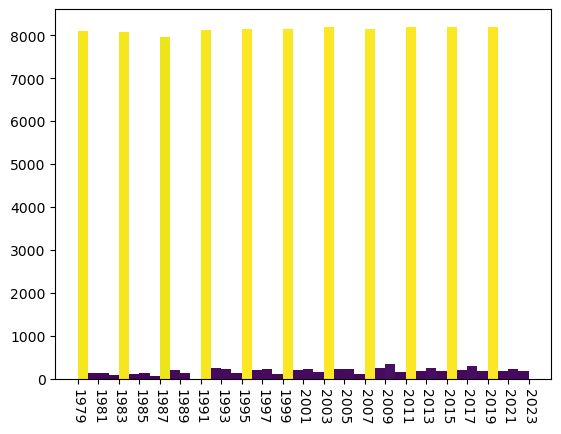

In [14]:
import datetime
from matplotlib import colors, pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

dfTemp = dfAlcaldes
dfTemp['Year'] = pd.DatetimeIndex(dfAlcaldes['FECHA POSESIÓN']).year

fig, ax = plt.subplots()

value = dfTemp['Year']
value=value.dropna()
N, bins, patches = ax.hist(value,bins=int(datetime.date.today().year-value.min()))    

# Calcula los puntos medios de las barras
#bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Dibuja una línea que conecta los puntos superiores de cada barra
#plt.plot(bin_centers, N, '-')

# Ajusta las etiquetas del eje x para que aparezcan en cada año
ax.set_xticks(np.arange(value.min(), value.max()+1, 2))
# Ajusta las etiquetas del eje x para que aparezcan en cada año y las rota 90 grados
ax.set_xticklabels(np.arange(int(value.min()), int(value.max())+1, 2), rotation=-90)

fracs = N / N.max()

#Se normaliza el valor de N / NMax correspondiente a los valores de cantidad
norm = colors.Normalize(fracs.min(), fracs.max())

# Loop entre cada objeto y se pondra los colores correspondientes
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

plt.show()

**TOP 10 PARTIDOS POLÍTICOS Y CANTIDAD DE ALCALDES**

Vemos que lo lidera el PSOE con el PP por una paliza increible, pero vemos también que hay una coalición que entra en el podio que es la de coalición popular

C:\Users\diego.guizanlopez\AppData\Local\Temp\ipykernel_5412\1715453474.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(conteo.index, rotation=-90)


[Text(0, 0, 'PSOE'),
 Text(1, 0, 'PP'),
 Text(2, 0, 'IND'),
 Text(3, 0, 'CIU'),
 Text(4, 0, 'UCD'),
 Text(5, 0, 'OTROS'),
 Text(6, 0, 'AP/PDP/UL'),
 Text(7, 0, 'AP'),
 Text(8, 0, 'PAR'),
 Text(9, 0, 'IU')]

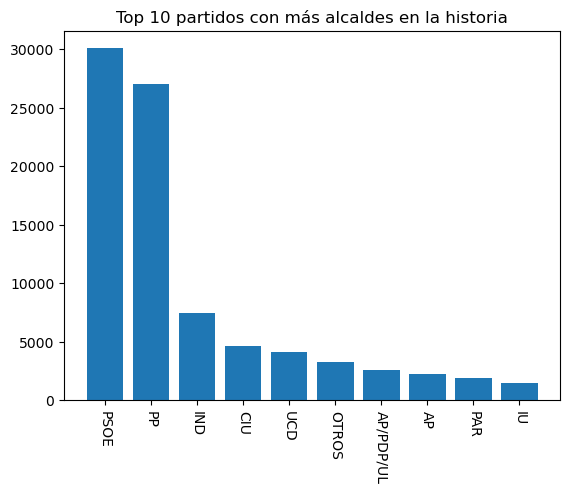

In [23]:
dfTemp=dfAlcaldes
conteo=dfTemp['LISTA'].value_counts().nlargest(10)

fig, ax = plt.subplots()

ax.bar(conteo.index, conteo.values)
ax.set_title('Top 10 partidos con más alcaldes en la historia')
ax.set_xticklabels(conteo.index, rotation=-90)
